# Full attack detection by Random Forest (CICID-IDS2017 dataset)

## Построение модели

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import pandas as pd
import time

#тренировочный набор
train_df = pd.read_csv('Preprocessed_train_data_selection.csv', low_memory=True)
#тестовый набор
test_df = pd.read_csv('Preprocessed_test_data_selection.csv', low_memory=True)


y_train, x_train = train_df["Label"], train_df.drop(columns=["Label"]).copy()

y_test, x_test = test_df["Label"], test_df.drop(columns=["Label"]).copy()

#На всякий случай запускаем проверку на соответствие признаков
miss_cols = set(x_train.columns) - set(x_test.columns)
extra_cols = set(x_test.columns) - set(x_train.columns)

if miss_cols or extra_cols:
    print(f"[!] Предупреждение: есть несоответствие в колонках между train и test")
    print(f"Отсутствуют в test: {missing_cols}")
    print(f"Лишние в test: {extra_cols}")
else:
    print("Данные успешно загружены, ошибок не возникло!")

Данные успешно загружены, ошибок не возникло!


### Шаг 1 - обучение модели RandomForestCl

In [5]:
#Обучение модели
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, oob_score=True, n_jobs=-1)

#Обучение и вычисление времени обучения
start_time = time.time()
rfc.fit(x_train, y_train)
end_time = time.time()

training_time = end_time - start_time

print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')



y_pred = rfc.predict(x_test)


Время обучения модели: 7.59 секунд



In [6]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9587525369830103

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    522552
           1       0.06      0.95      0.12       587
           2       1.00      1.00      1.00     38408
           3       0.95      1.00      0.97      3088
           4       0.90      1.00      0.95     69037
           5       0.94      0.99      0.96      1650
           6       0.99      0.99      0.99      1739
           7       0.96      1.00      0.98      2380
           8       0.99      1.00      1.00     47641
           9       0.13      0.96      0.24      1769
          10       0.38      0.89      0.53       452

    accuracy                           0.96    689303
   macro avg       0.76      0.98      0.79    689303
weighted avg       0.99      0.96      0.97    689303


Confusion Matrix:
[[494539   8318    151    133   7371    105     16     90    293  10896
     640]
 [    28    559      0      0    

### Шаг 2 - Отбор наиболее важных признаков

In [8]:
#Отбор признаков с помощью sfm
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(estimator=rfc, threshold="mean")

sfm.fit(x_train, y_train)

x_train_selected_sfm = sfm.transform(x_train)
x_test_selected_sfm = sfm.transform(x_test)

features_selected_sfm = x_train.columns[sfm.get_support()]
print("Выбранные признаки с помощью SFM:\n", features_selected_sfm.tolist())
print("Количество важных признаков: ", len(features_selected_sfm))

Выбранные признаки с помощью SFM:
 ['Flow_Duration', 'Total_Fwd_Packets', 'Total_Length_of_Fwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Mean', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Flow_Bytes_s', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Min', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Fwd_Header_Length', 'Bwd_Packets_s', 'PSH_Flag_Count']
Количество важных признаков:  17


In [10]:
#Вывод наиболее важных признаков по мнению sfm
display("оригинальных признаков; {}, выбранных признаков (SFM): {}"
        .format(x_train.shape[1], x_train_selected_sfm.shape[1]))

#важности всех признаков
all_importances_features = rfc.feature_importances_

#Получение индексов выбранных признаков по мнению sfm
selected_indices_sfm = sfm.get_support(indices=True)

#Важности только выбранных признаков
selected_importances_sfm = all_importances_features[selected_indices_sfm]

#Сортировка индексов выбранных признаков по важности
sorted_indices_selected_sfm = np.argsort(selected_importances_sfm)[::-1]

#формируем названия и значения важностей в правильном порядке
top_n = 19 #кол-во выбранных признаков

for idx, sorted_idx in enumerate(sorted_indices_selected_sfm[:top_n]):
    feature_index = selected_indices_sfm[sorted_idx] #реальный индекс в исходных данных
    feature_name = x_train.columns[feature_index] #имя признака
    importance_score = selected_importances_sfm[sorted_idx] #очки важности
    print(f'{idx+1}.\t{feature_name} - {importance_score:.4f}')

'оригинальных признаков; 41, выбранных признаков (SFM): 17'

1.	Total_Length_of_Fwd_Packets - 0.0716
2.	Fwd_Packet_Length_Max - 0.0665
3.	Fwd_Packet_Length_Mean - 0.0590
4.	Bwd_Packet_Length_Max - 0.0584
5.	Flow_Bytes_s - 0.0551
6.	Flow_IAT_Mean - 0.0551
7.	Bwd_Packets_s - 0.0526
8.	Flow_Packets_s - 0.0512
9.	Flow_Duration - 0.0497
10.	Fwd_Header_Length - 0.0464
11.	Bwd_Packet_Length_Min - 0.0436
12.	Flow_IAT_Min - 0.0423
13.	Fwd_IAT_Min - 0.0363
14.	Total_Fwd_Packets - 0.0358
15.	Bwd_IAT_Total - 0.0300
16.	PSH_Flag_Count - 0.0293
17.	Bwd_IAT_Mean - 0.0256


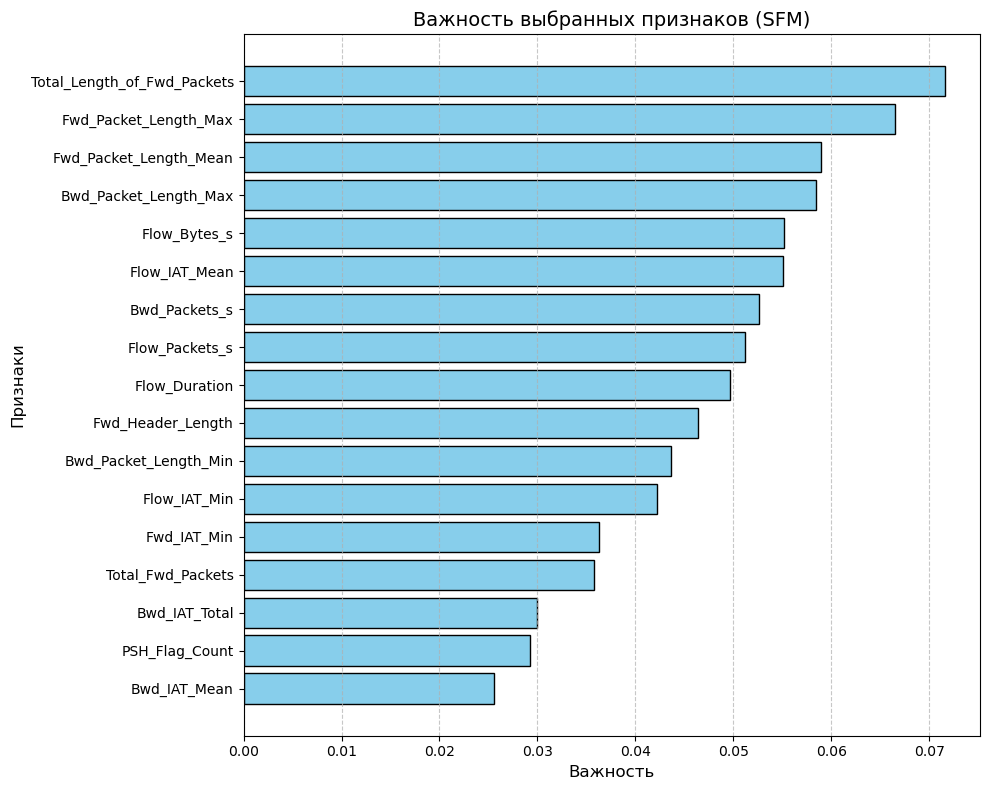

In [11]:
#Строим график с наиболее важными призанаками
#Отображение в графическом виде
import matplotlib.pyplot as plt

# Параметры графика
top_n = 18  # количество выводимых признаков

# Сортируем выбранные признаки по важности
sorted_indices_selected_sfm = np.argsort(selected_importances_sfm)[::-1]
top_indices = sorted_indices_selected_sfm[:top_n]

# Получаем названия и значения важностей
top_names = [x_train.columns[selected_indices_sfm[i]] for i in top_indices]
top_scores = selected_importances_sfm[top_indices]

# Визуализация
plt.figure(figsize=(10, 8))
plt.title('Важность выбранных признаков (SFM)', fontsize=14)
plt.barh(range(len(top_scores)), top_scores, color='skyblue', edgecolor='black')
plt.yticks(range(len(top_scores)), top_names)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sfm_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
""" Тестовые проверки данных """

#проверка размеров выборок
print("Train shape:", x_train_selected_sfm.shape)
print("Test shape:", x_test_selected_sfm.shape)

from collections import Counter

print("Классы в train:", sorted(Counter(y_train).items()))
print("Классы в test:", sorted(Counter(y_test).items()))

Train shape: (459617, 17)
Test shape: (689303, 17)
Классы в train: [(0, 100000), (1, 10000), (2, 89617), (3, 10000), (4, 100000), (5, 10000), (6, 10000), (7, 10000), (8, 100000), (9, 10000), (10, 10000)]
Классы в test: [(0, 522552), (1, 587), (2, 38408), (3, 3088), (4, 69037), (5, 1650), (6, 1739), (7, 2380), (8, 47641), (9, 1769), (10, 452)]


#### Сохранение набора данных с отобранными признаками

In [14]:

# Преобразуем numpy.ndarray обратно в DataFrame
x_train_selected_df = pd.DataFrame(x_train_selected_sfm, columns=features_selected_sfm)
x_train_selected_df['Label'] = y_train.copy()

x_test_selected_df = pd.DataFrame(x_test_selected_sfm, columns=features_selected_sfm)
x_test_selected_df['Label'] = y_test.copy()

x_train_selected_df.to_csv('features_importances_train_data_selection.csv', index=False)
print("Файл тренировочной выборки успешно сохранен")

#Сохранение тестовой выборки с отобранными признаками в файл
x_test_selected_df.to_csv('features_importances_test_data_selection.csv', index=False)
print("Файл тестовой выборки, успешно сохранен")

print("\nЭтапы препроцессинга файлов успешно завершены!")

Файл тренировочной выборки успешно сохранен
Файл тестовой выборки, успешно сохранен

Этапы препроцессинга файлов успешно завершены!


### Шаг 3 - построение модели на отобранных признаках

In [16]:
#Обучаем новый лес на отобранных признаках
new_rfc = RandomForestClassifier(class_weight='balanced',random_state=42, oob_score=True, n_jobs=-1)

#Обучение
start_time = time.time()

new_rfc.fit(x_train_selected_sfm, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

y_pred = new_rfc.predict(x_test_selected_sfm)


Время обучения модели: 7.26 секунд



In [17]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9551387415983972

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    522552
           1       0.06      0.95      0.11       587
           2       0.99      1.00      1.00     38408
           3       0.90      0.99      0.94      3088
           4       0.90      1.00      0.94     69037
           5       0.93      0.99      0.96      1650
           6       0.99      1.00      0.99      1739
           7       0.97      1.00      0.98      2380
           8       0.99      1.00      1.00     47641
           9       0.12      0.96      0.22      1769
          10       0.33      0.89      0.48       452

    accuracy                           0.96    689303
   macro avg       0.74      0.97      0.78    689303
weighted avg       0.98      0.96      0.97    689303


Confusion Matrix:
[[492122   8739    207    324   7807    112     17     83    292  12069
     780]
 [    30    557      0      0    

### Шаг 4 - Улучшение весов для классов модели RandomForest

In [21]:
from collections import Counter
counts = Counter(y_train)
total = sum(counts.values())
class_weights = {cls: round((total / count), 3) for cls, count in counts.items()}

print(f"Веса для классов: {class_weights}")

Веса для классов: {0: 4.596, 1: 45.962, 2: 5.129, 3: 45.962, 4: 4.596, 5: 45.962, 6: 45.962, 7: 45.962, 8: 4.596, 9: 45.962, 10: 45.962}


#### Построение модели RandomForest с настроенными весами

In [23]:
#построение модели с весами классов
new_rfc_2 = RandomForestClassifier(class_weight=class_weights,random_state=42, oob_score=True, n_jobs=-1)
#Обучение
start_time = time.time()

new_rfc_2.fit(x_train_selected_sfm, y_train)

end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

y_pred = new_rfc_2.predict(x_test_selected_sfm)


Время обучения модели: 7.45 секунд



In [24]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9552011234536917

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    522552
           1       0.06      0.95      0.11       587
           2       0.99      1.00      1.00     38408
           3       0.90      0.99      0.95      3088
           4       0.90      1.00      0.94     69037
           5       0.93      0.99      0.96      1650
           6       0.98      0.99      0.99      1739
           7       0.97      1.00      0.98      2380
           8       0.99      1.00      1.00     47641
           9       0.12      0.96      0.22      1769
          10       0.33      0.89      0.49       452

    accuracy                           0.96    689303
   macro avg       0.74      0.97      0.78    689303
weighted avg       0.98      0.96      0.97    689303


Confusion Matrix:
[[492169   8739    212    311   7765    117     18     79    292  12068
     782]
 [    30    557      0      0    

In [25]:
#Улучшение весов на проблемных классах вручную
# Вручную усили веса для проблемных классов
class_weights[1] *= 1.4
class_weights[9] *= 1.2
class_weights[10] *= 1.8

print(f"Веса для классов: {class_weights}")

Веса для классов: {0: 4.596, 1: 64.3468, 2: 5.129, 3: 45.962, 4: 4.596, 5: 45.962, 6: 45.962, 7: 45.962, 8: 4.596, 9: 55.1544, 10: 82.73160000000001}


In [26]:
#обучение на обновленных весах
new_rfc_3 = RandomForestClassifier(class_weight=class_weights,random_state=42, oob_score=True, n_jobs=-1)
new_rfc_3.fit(x_train_selected_sfm, y_train)
y_pred = new_rfc_3.predict(x_test_selected_sfm)

In [27]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9511637117494048

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    522552
           1       0.06      0.98      0.11       587
           2       0.99      1.00      1.00     38408
           3       0.90      0.99      0.94      3088
           4       0.90      1.00      0.94     69037
           5       0.93      0.99      0.96      1650
           6       0.99      0.99      0.99      1739
           7       0.97      1.00      0.98      2380
           8       0.99      1.00      1.00     47641
           9       0.11      0.97      0.20      1769
          10       0.33      0.89      0.48       452

    accuracy                           0.95    689303
   macro avg       0.74      0.98      0.78    689303
weighted avg       0.98      0.95      0.97    689303


Confusion Matrix:
[[489352   9766    224    318   7774    118     16     77    293  13834
     780]
 [    13    574      0      0    

In [30]:
#Сохранение весов в файл
weights_df = pd.DataFrame(list(class_weights.items()), columns=['Class','Weight'])
weights_df.to_csv('class_weights.csv', index=False)

### Шаг 5 - Оптимизация гиперпараметров в 2 раунда

#### Раунд 1 - используем RandomizedSearchCV

In [41]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(par) for par in np.linspace(start=100, stop=1000, num=10)]
max_features = ['log2', 'sqrt']
max_depth = [int(par) for par in np.linspace(start=1, stop=15, num=15)]
min_samples_split = [int(par) for par in np.linspace(start=2, stop=50, num=10)]
min_samples_leaf = [int(par) for par in np.linspace(start=2, stop=50, num=10)]
bootstrap = [True, False]

H_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}


rfc_hp = RandomForestClassifier(random_state=1)
rfc_hp.get_params().keys()

func_rcv = RandomizedSearchCV(rfc_hp, H_params, n_iter=100, cv=3,
                        verbose=1, n_jobs=-1, random_state=1)

In [43]:
start_time = time.time()
func_rcv.fit(x_train_selected_sfm, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Время обучения модели: 3763.30 секунд



In [44]:
display(f'Лучшие параметры для модели на сонове RandomizedSearchCV: {func_rcv.best_params_}')

"Лучшие параметры для модели на сонове RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 39, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': False}"

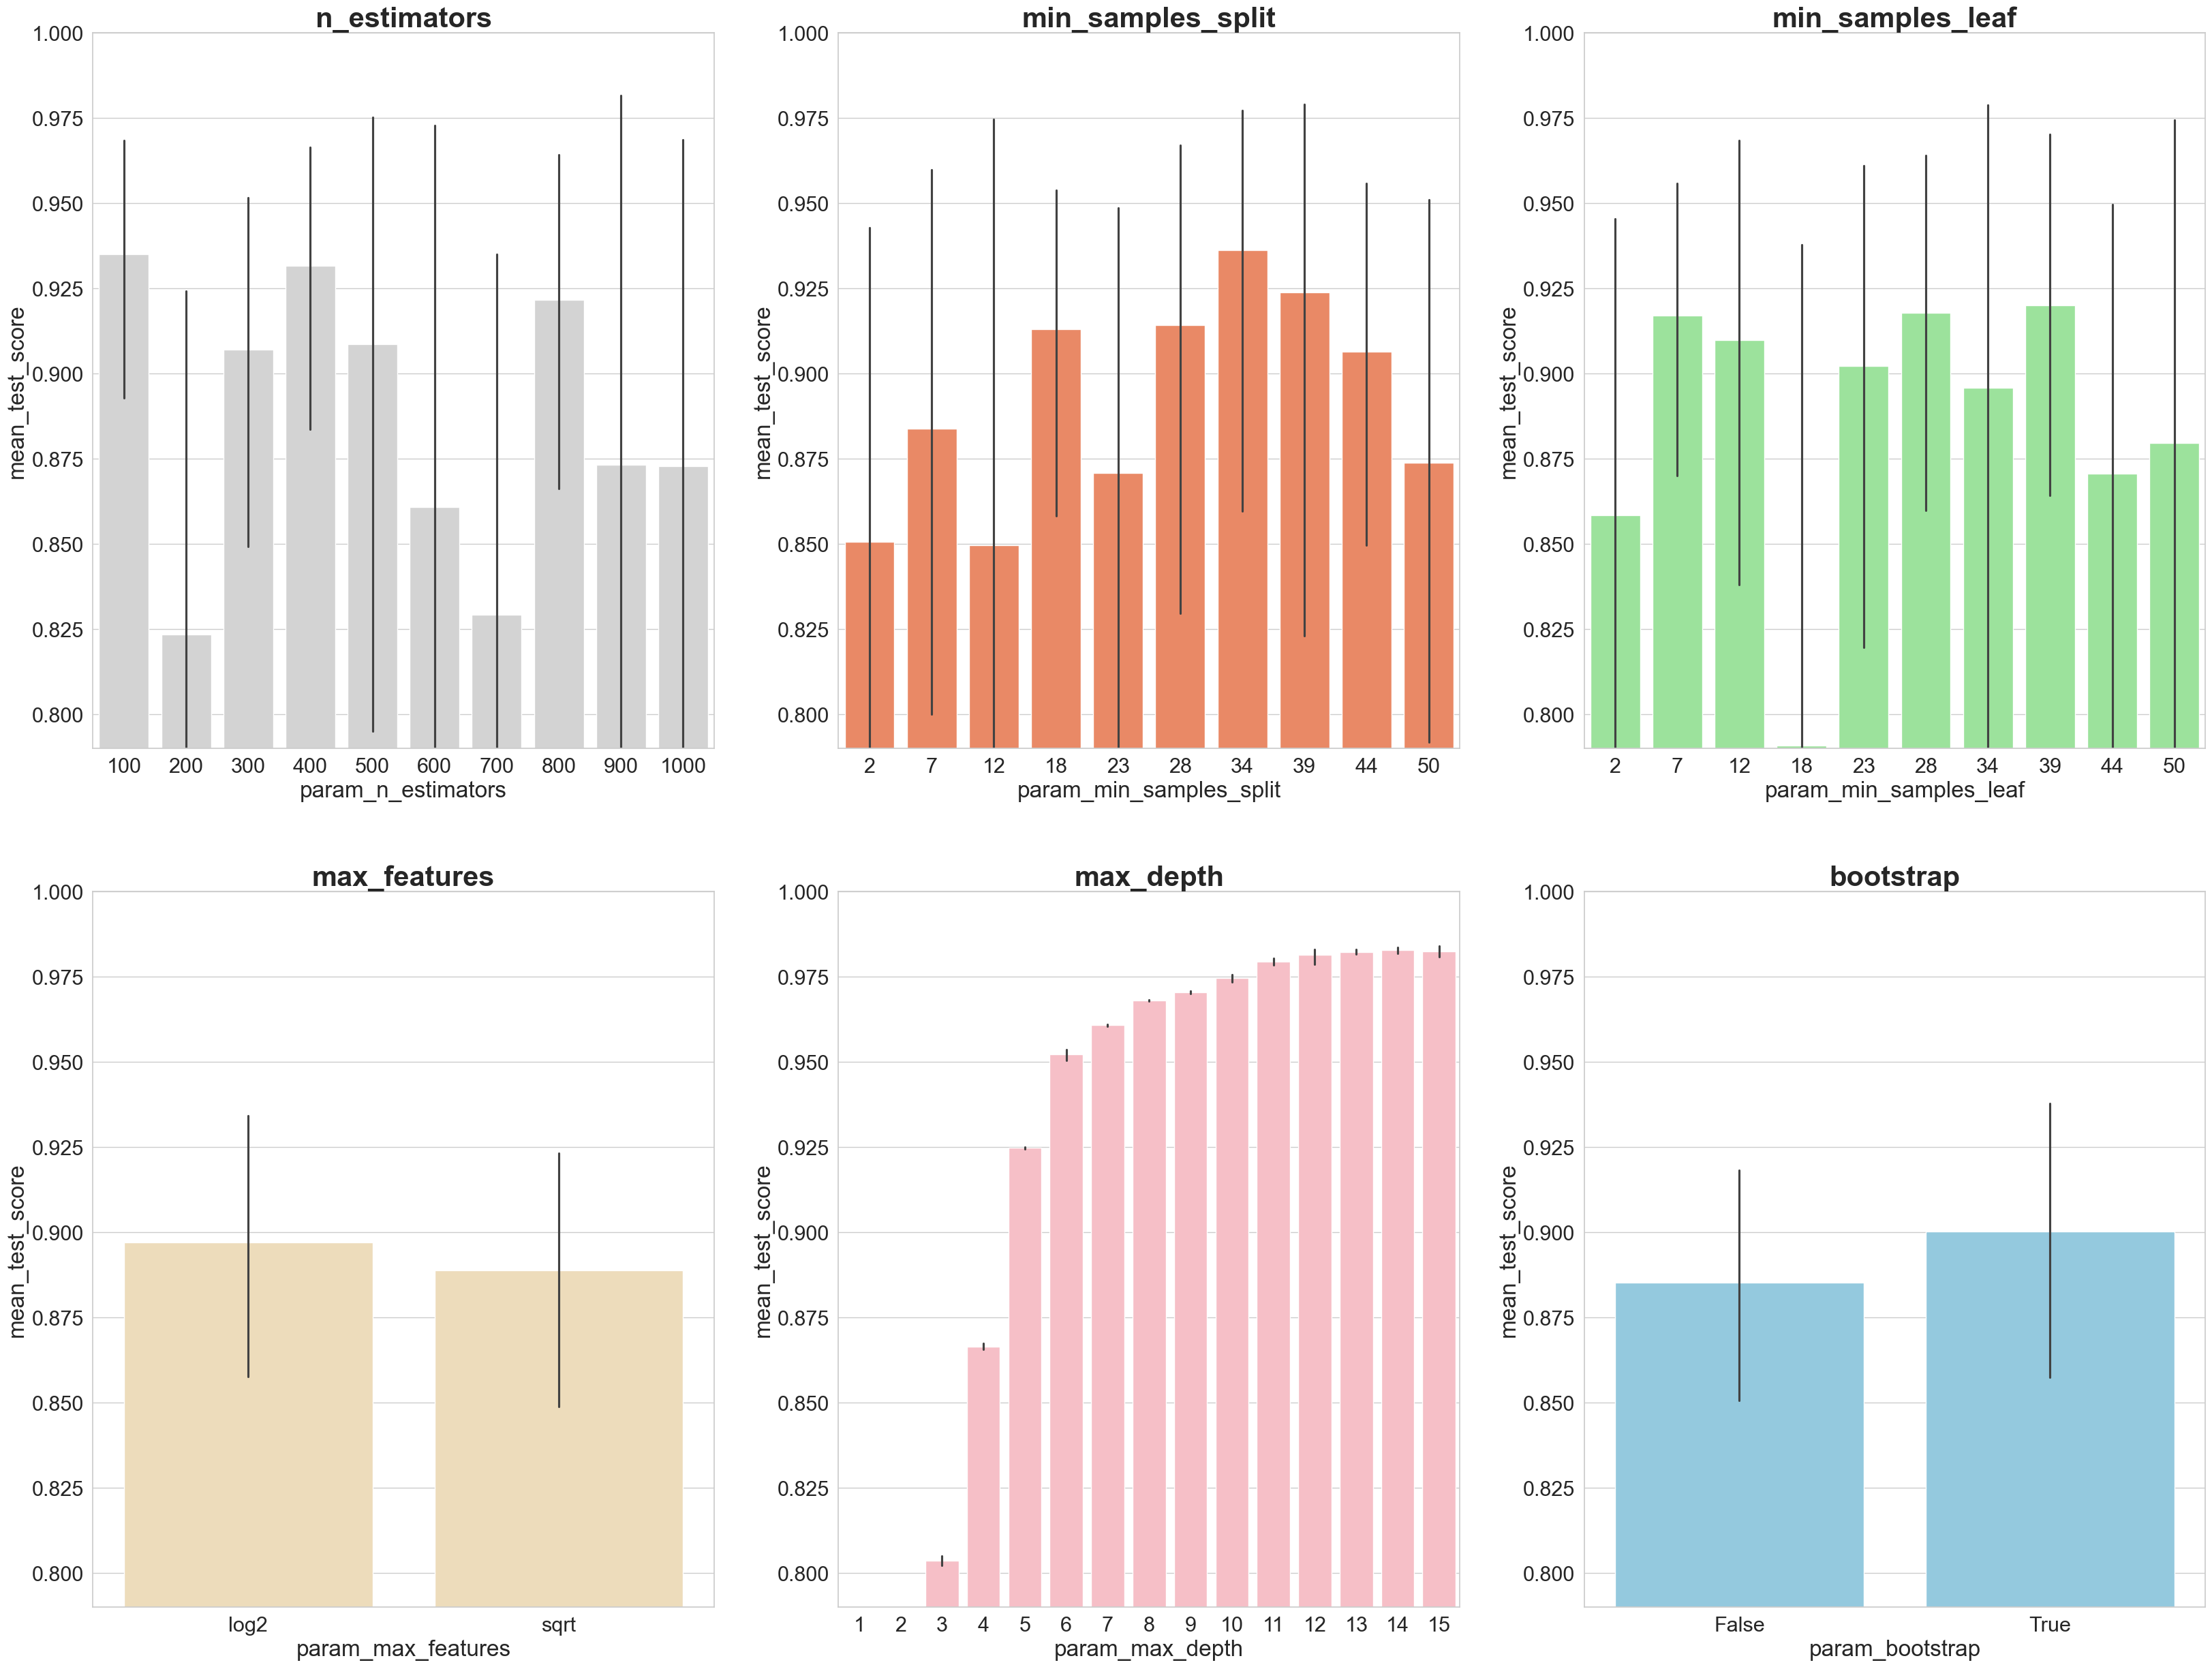

In [55]:
import seaborn as sns

#преобразовываем в датасет, для построения графика на основе значений
rcv_df = pd.DataFrame(func_rcv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
cv_df = rcv_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

#Создаем графики, чтобы понять какие значения подходят лучше всего в среднем
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(40,30)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rcv_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.79,1])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rcv_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.79,1])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rcv_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.79,1])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rcv_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.79,1])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rcv_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.79,1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rcv_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.79,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

#### Раунд 2 - используем GridSearchCV

In [57]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100,400,800]
max_features = ['log2']
max_depth = [13]
min_samples_split = [34,39]
min_samples_leaf = [7,34,39]
bootstrap = [True]

H_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

gscv = GridSearchCV(rfc_hp, H_params, cv = 3, verbose = 1, n_jobs=-1)

In [59]:
start_time = time.time()
gscv.fit(x_train_selected_sfm, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Время обучения модели: 994.47 секунд



In [60]:
best_rfc = gscv.best_estimator_
display(f"Best params: {gscv.best_params_}")
display(f"Best estimator: {gscv.best_estimator_}")

"Best params: {'bootstrap': True, 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 34, 'n_estimators': 800}"

"Best estimator: RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=7,\n                       min_samples_split=34, n_estimators=800, random_state=1)"

### Шаг 6 - Построение финальной модели с оптимизированными параметрами

In [35]:
final_rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=13,
    max_features='log2',
    min_samples_leaf=7,
    min_samples_split=34,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1
)
start_time = time.time()
final_rf.fit(x_train_selected_sfm, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f'\nВремя обучения модели: {training_time:.2f} секунд\n')

y_pred = final_rf.predict(x_test_selected_sfm)


Время обучения модели: 51.55 секунд



In [36]:
#Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9702975324349379

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    522552
           1       0.23      0.65      0.34       587
           2       1.00      1.00      1.00     38408
           3       0.88      0.99      0.93      3088
           4       0.88      1.00      0.94     69037
           5       0.89      0.99      0.94      1650
           6       0.99      0.99      0.99      1739
           7       0.97      1.00      0.99      2380
           8       0.99      1.00      1.00     47641
           9       0.21      0.86      0.34      1769
          10       0.14      0.88      0.24       452

    accuracy                           0.97    689303
   macro avg       0.74      0.94      0.79    689303
weighted avg       0.98      0.97      0.97    689303


Confusion Matrix:
[[502888   1316    114    417   9188    194     16     67    305   5687
    2360]
 [   204    383      0      0    

In [37]:
print(f"OOB SCORE: {rfc.oob_score_}")

OOB SCORE: 0.9866976199748921


In [38]:
from sklearn.metrics import f1_score
# Посчитай F1-score
y_pred_oob = final_rf.predict(x_train_selected_sfm)
f1 = f1_score(y_train, y_pred_oob, average='macro')
print("F1-macro:", f1)

F1-macro: 0.9760659601236451


### Шаг 7 - Сохранение модели

In [43]:
import pickle

with open('rf_final_model.pkl', 'wb') as file:
    pickle.dump(final_rf, file)
    
print('Модель успешно сохранена в файл')

Модель успешно сохранена в файл
